In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.utils import make_grid
# import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import math
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [2]:
df = pd.read_csv("train.csv")

In [3]:
len(df)

42000

In [4]:
df['label'].value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [5]:
# Find the maximum number of occurrences of any digit
max_size = df['label'].value_counts().max()

# Use pd.concat to create a list of dataframes to be concatenated
frames = [df]  # Start with the original dataframe

# Loop through each class group and append necessary duplicates
for class_index, group in df.groupby('label'):
    samples_to_add = max_size - len(group)
    if samples_to_add > 0:
        frames.append(group.sample(samples_to_add, replace=True))

# Concatenate all the frames together and shuffle the dataframe
df = pd.concat(frames).sample(frac=1).reset_index(drop=True)

# Check the new value counts to confirm balancing
print(df['label'].value_counts())

label
1    4684
5    4684
3    4684
0    4684
9    4684
6    4684
2    4684
7    4684
8    4684
4    4684
Name: count, dtype: int64


In [6]:
# 1 represents real, 0 fake
df['label'] = 1

In [7]:
X_discriminator = df.drop('label', axis=1)
y_discriminator = torch.tensor(df['label'].values, dtype=torch.float32)

In [8]:
pixel_columns = df.shape[1] - 1  # subtracting 1 for the label column

image_side_length = int(pixel_columns**0.5)
print(f"Each image is {image_side_length}x{image_side_length} pixels.")

Each image is 28x28 pixels.


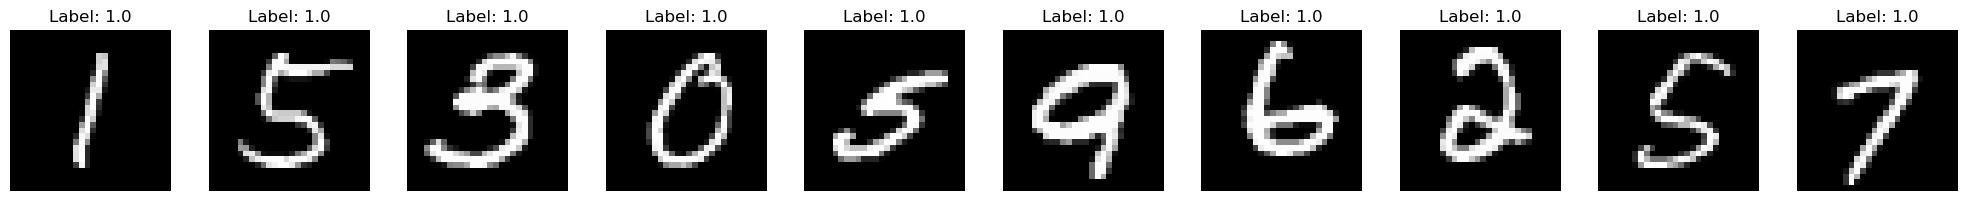

In [9]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  
for i, ax in enumerate(axes):
    # Reshape each row into 28x28 array and plot
    img = X_discriminator.iloc[i].to_numpy().reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_discriminator[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
X_discriminator = X_discriminator.values.reshape(-1, 1, 28, 28)
X_discriminator = (torch.tensor(X_discriminator).float() / 255.0) * 2 - 1

In [11]:
dataset_discriminator = TensorDataset(X_discriminator, y_discriminator)
loader_discriminator = DataLoader(dataset_discriminator, batch_size=64, shuffle=True)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features=128*7*7, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        x = F.relu(self.conv6(x))
        x = x.view(-1, 128*7*7)
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [13]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(in_features=noise_dim, out_features=noise_dim) # (1, 49) -> (1, 7, 7)
        self.convT1 = nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size=4, stride=1)  # (1, 7, 7) -> (1, 10, 10)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2) # (1, 10, 10) -> (1, 22, 22)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.convT3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1) # (1, 22, 22) -> (1, 24, 24)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.convT4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1) # (1, 24, 24) -> (1, 26, 26)
        self.bn4 = nn.BatchNorm2d(num_features=16)
        self.dropout = nn.Dropout(0.3)
        self.convT5 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1) # (1, 26, 26) -> (1, 28, 28)

    def forward(self, x):
        x = F.leaky_relu(self.fc(x))
        x = x.view(-1, 1, int(math.sqrt(noise_dim)), int(math.sqrt(noise_dim)))
        x = F.relu(self.bn1(self.convT1(x)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        x = self.dropout(x)
        x = torch.tanh(self.convT5(x))
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 49
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)

optim_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# scheduler_G = StepLR(optimizer=optim_G, step_size=5, gamma=0.4)
# scheduler_D = StepLR(optimizer=optim_D, step_size=5, gamma=0.4)

100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.78it/s, loss_D=1.05, loss_G=3.41]


Epoch [1/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [1/100] - Average D loss: 1.0773, Average G loss: 1.4229


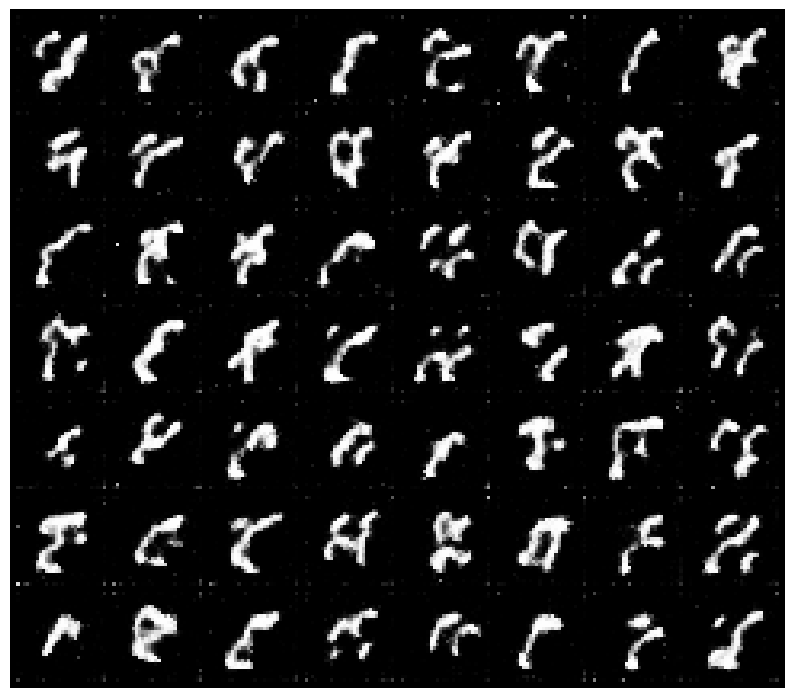

100%|█████████████████████████████████████████████████████| 732/732 [00:21<00:00, 33.47it/s, loss_D=1.12, loss_G=0.959]


Epoch [2/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [2/100] - Average D loss: 1.1956, Average G loss: 1.0201


100%|██████████████████████████████████████████████████████| 732/732 [00:21<00:00, 33.38it/s, loss_D=1.18, loss_G=1.12]


Epoch [3/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [3/100] - Average D loss: 1.0902, Average G loss: 1.1695


100%|██████████████████████████████████████████████████████| 732/732 [00:21<00:00, 33.38it/s, loss_D=1.35, loss_G=1.55]


Epoch [4/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [4/100] - Average D loss: 1.0624, Average G loss: 1.2725


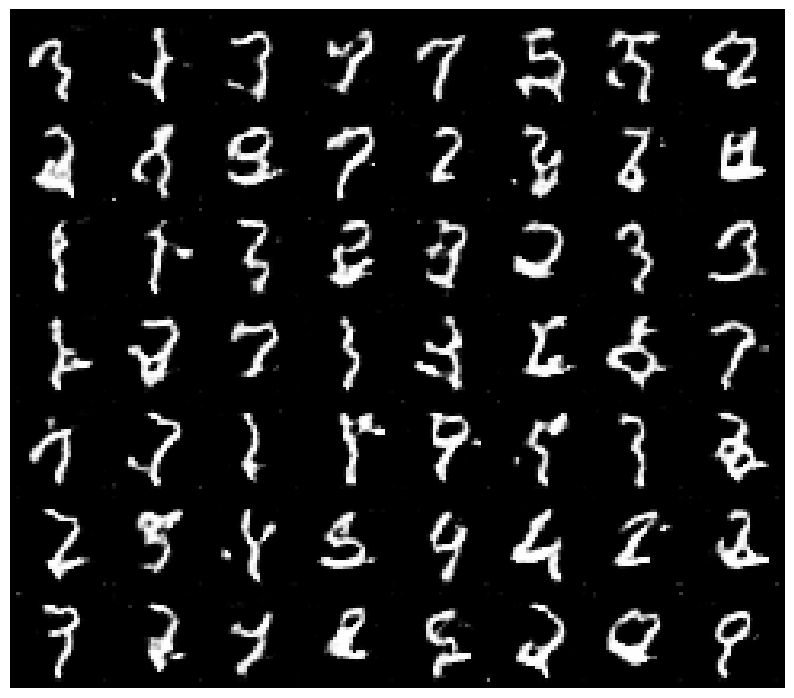

100%|██████████████████████████████████████████████████████| 732/732 [00:21<00:00, 33.29it/s, loss_D=1.42, loss_G=3.23]


Epoch [5/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [5/100] - Average D loss: 1.0353, Average G loss: 1.3036


100%|██████████████████████████████████████████████████████| 732/732 [00:23<00:00, 31.64it/s, loss_D=0.78, loss_G=1.71]


Epoch [6/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [6/100] - Average D loss: 1.0003, Average G loss: 1.3509


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 31.88it/s, loss_D=0.89, loss_G=1.48]


Epoch [7/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [7/100] - Average D loss: 0.9179, Average G loss: 1.5318


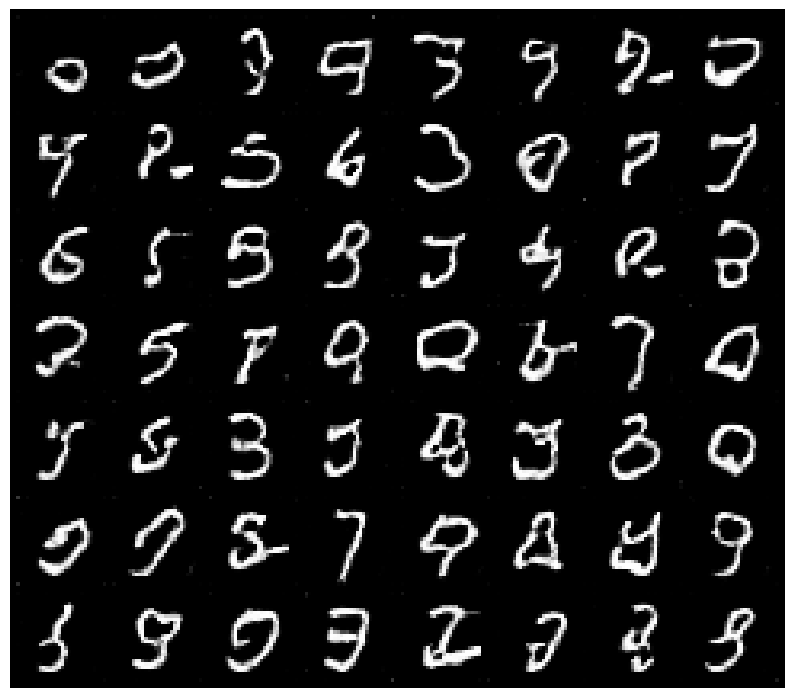

100%|█████████████████████████████████████████████████████| 732/732 [00:23<00:00, 31.82it/s, loss_D=0.568, loss_G=1.58]


Epoch [8/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [8/100] - Average D loss: 0.8232, Average G loss: 1.7475


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.76it/s, loss_D=0.907, loss_G=1.05]


Epoch [9/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [9/100] - Average D loss: 0.7873, Average G loss: 1.8748


100%|█████████████████████████████████████████████████████| 732/732 [00:31<00:00, 23.48it/s, loss_D=0.667, loss_G=2.24]


Epoch [10/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [10/100] - Average D loss: 0.7404, Average G loss: 2.0047


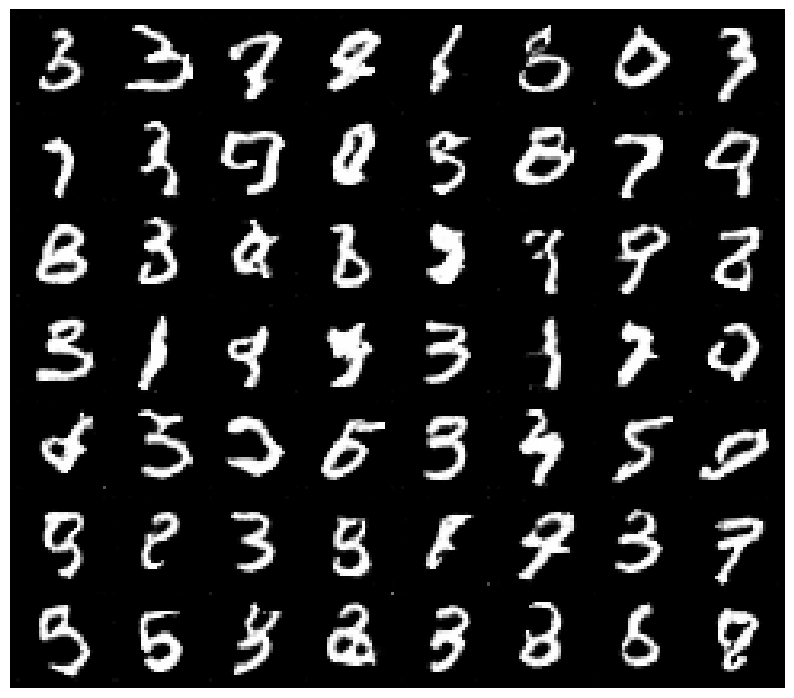

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.15it/s, loss_D=0.648, loss_G=2.33]


Epoch [11/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [11/100] - Average D loss: 0.7205, Average G loss: 2.0599


100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.24it/s, loss_D=0.77, loss_G=2.08]


Epoch [12/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [12/100] - Average D loss: 0.7043, Average G loss: 2.1082


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.17it/s, loss_D=0.808, loss_G=1.79]


Epoch [13/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [13/100] - Average D loss: 0.6793, Average G loss: 2.2039


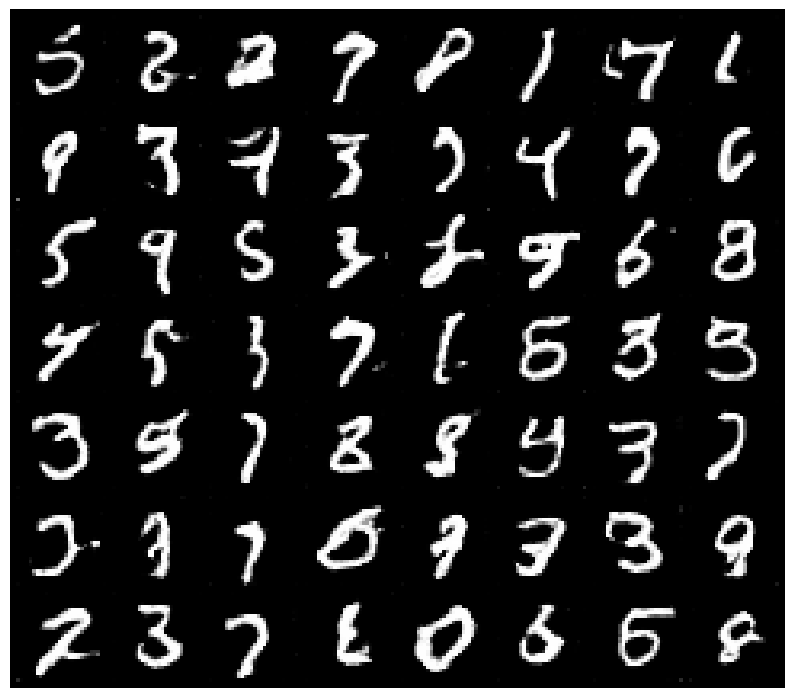

100%|█████████████████████████████████████████████████████| 732/732 [00:49<00:00, 14.76it/s, loss_D=0.681, loss_G=2.38]


Epoch [14/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [14/100] - Average D loss: 0.6697, Average G loss: 2.2357


100%|█████████████████████████████████████████████████████| 732/732 [00:26<00:00, 28.02it/s, loss_D=0.648, loss_G=1.83]


Epoch [15/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [15/100] - Average D loss: 0.6532, Average G loss: 2.2903


100%|█████████████████████████████████████████████████████| 732/732 [00:28<00:00, 26.02it/s, loss_D=0.556, loss_G=2.34]


Epoch [16/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [16/100] - Average D loss: 0.6454, Average G loss: 2.3304


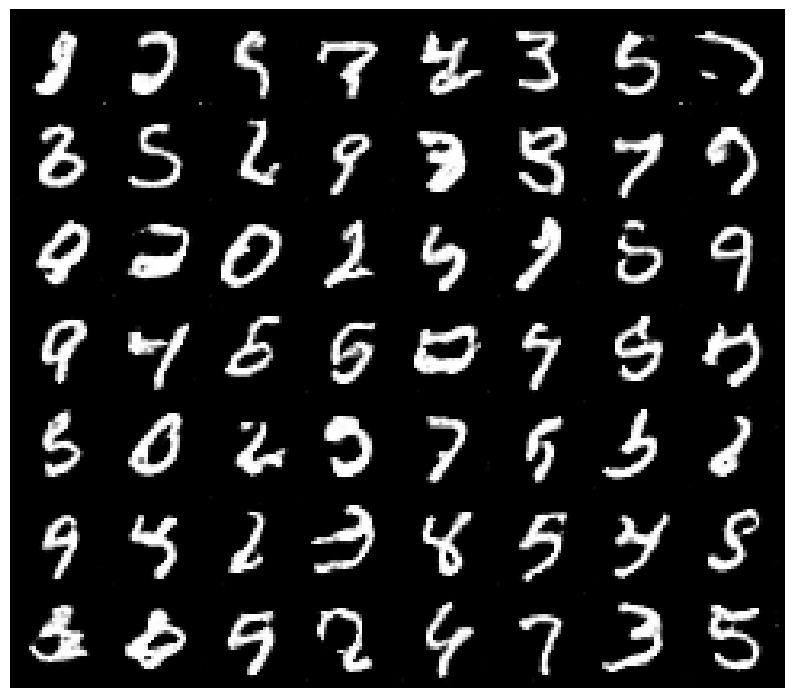

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.94it/s, loss_D=0.643, loss_G=2.28]


Epoch [17/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [17/100] - Average D loss: 0.6312, Average G loss: 2.3654


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.97it/s, loss_D=0.569, loss_G=2.51]


Epoch [18/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [18/100] - Average D loss: 0.6363, Average G loss: 2.3396


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.98it/s, loss_D=0.478, loss_G=2.24]


Epoch [19/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [19/100] - Average D loss: 0.6277, Average G loss: 2.3721


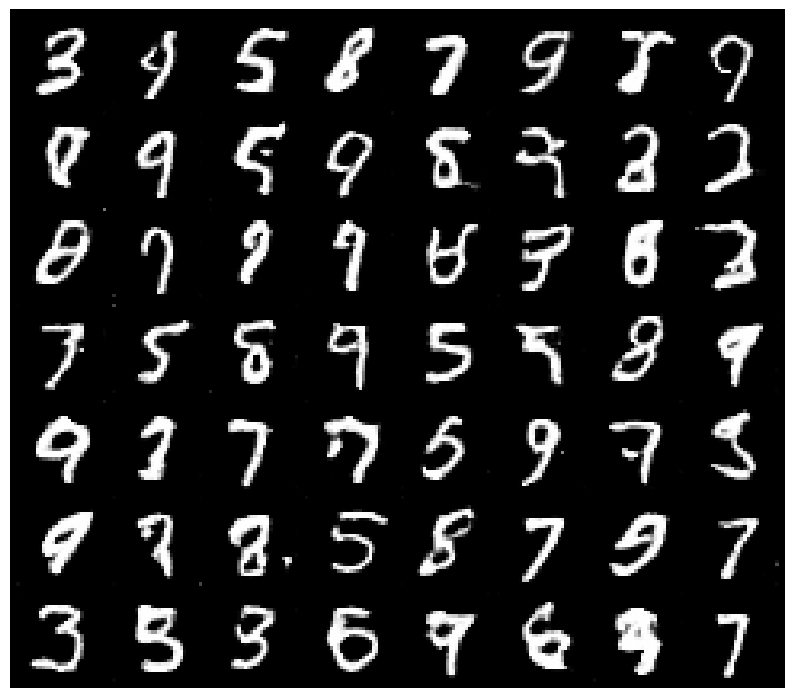

100%|██████████████████████████████████████████████████████| 732/732 [00:28<00:00, 25.96it/s, loss_D=0.683, loss_G=1.8]


Epoch [20/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [20/100] - Average D loss: 0.6260, Average G loss: 2.3587


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.88it/s, loss_D=0.558, loss_G=2.49]


Epoch [21/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [21/100] - Average D loss: 0.6124, Average G loss: 2.3791


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.997, loss_G=2.8]


Epoch [22/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [22/100] - Average D loss: 0.6100, Average G loss: 2.3901


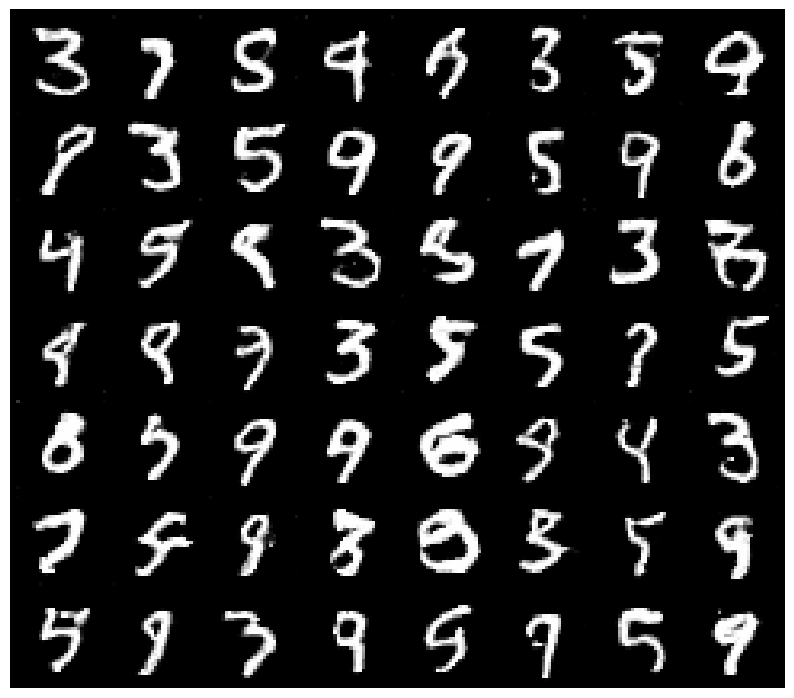

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.93it/s, loss_D=0.546, loss_G=2.35]


Epoch [23/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [23/100] - Average D loss: 0.6019, Average G loss: 2.3972


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.91it/s, loss_D=0.431, loss_G=2.51]


Epoch [24/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [24/100] - Average D loss: 0.5972, Average G loss: 2.3901


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.527, loss_G=2.58]


Epoch [25/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [25/100] - Average D loss: 0.5904, Average G loss: 2.4086


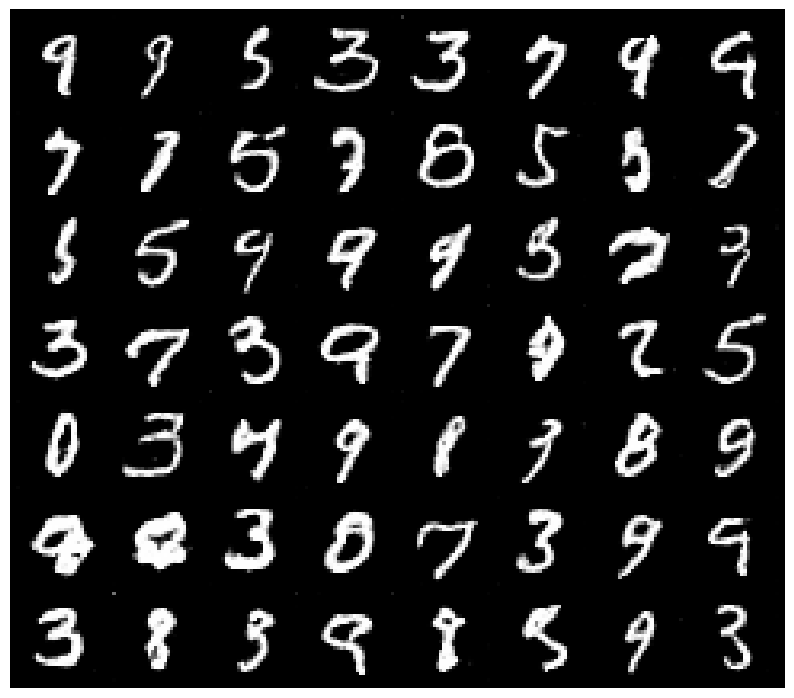

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.92it/s, loss_D=0.512, loss_G=2.58]


Epoch [26/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [26/100] - Average D loss: 0.5886, Average G loss: 2.4122


100%|█████████████████████████████████████████████████████| 732/732 [00:48<00:00, 15.01it/s, loss_D=0.622, loss_G=2.34]


Epoch [27/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [27/100] - Average D loss: 0.5833, Average G loss: 2.4103


100%|█████████████████████████████████████████████████████| 732/732 [00:35<00:00, 20.46it/s, loss_D=0.537, loss_G=2.09]


Epoch [28/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [28/100] - Average D loss: 0.5734, Average G loss: 2.4358


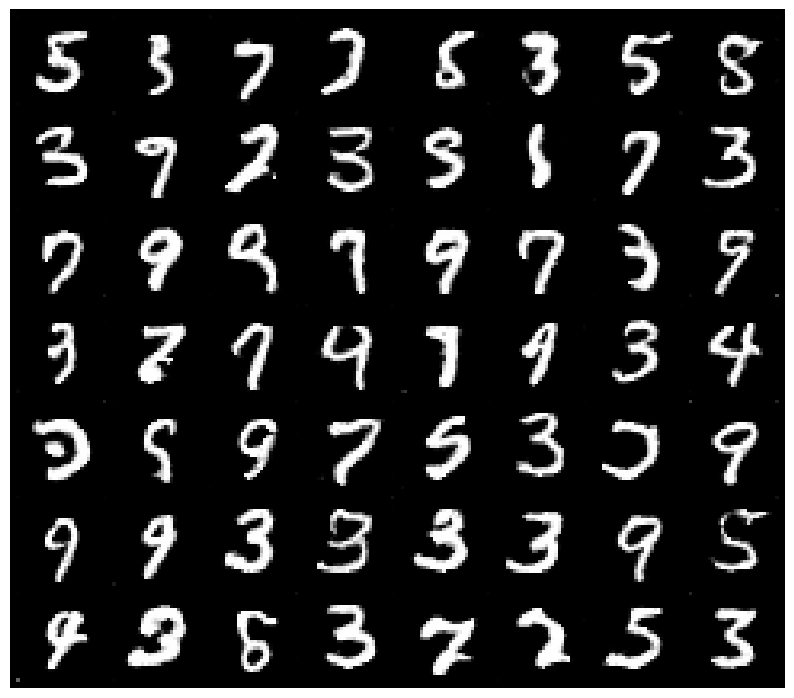

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.11it/s, loss_D=0.496, loss_G=2.33]


Epoch [29/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [29/100] - Average D loss: 0.5740, Average G loss: 2.4273


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.32it/s, loss_D=0.676, loss_G=2.55]


Epoch [30/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [30/100] - Average D loss: 0.5690, Average G loss: 2.4415


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.27it/s, loss_D=0.552, loss_G=2.85]


Epoch [31/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [31/100] - Average D loss: 0.5656, Average G loss: 2.4349


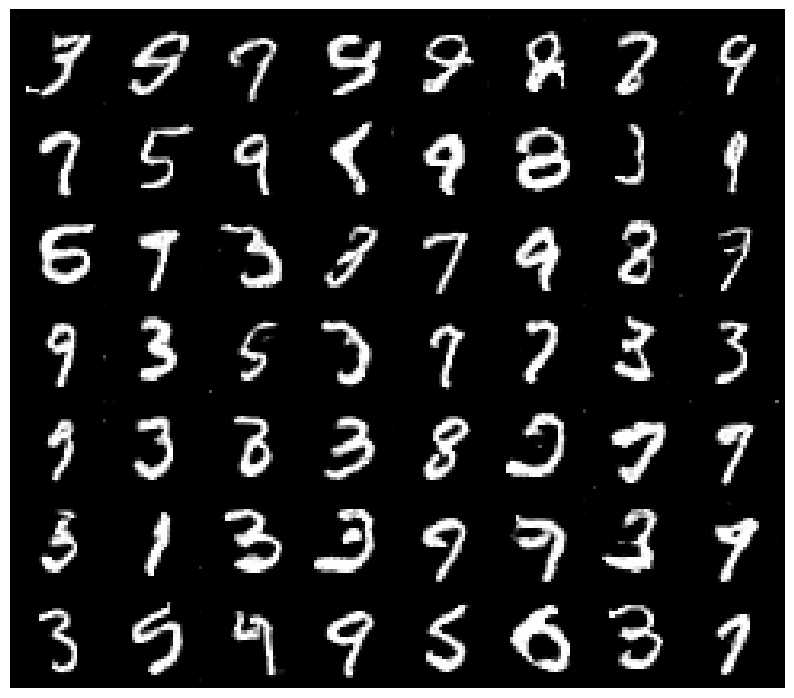

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.551, loss_G=2.67]


Epoch [32/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [32/100] - Average D loss: 0.5667, Average G loss: 2.4232


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.08it/s, loss_D=0.438, loss_G=2.97]


Epoch [33/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [33/100] - Average D loss: 0.5604, Average G loss: 2.4362


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.11it/s, loss_D=0.529, loss_G=2.41]


Epoch [34/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [34/100] - Average D loss: 0.5586, Average G loss: 2.4288


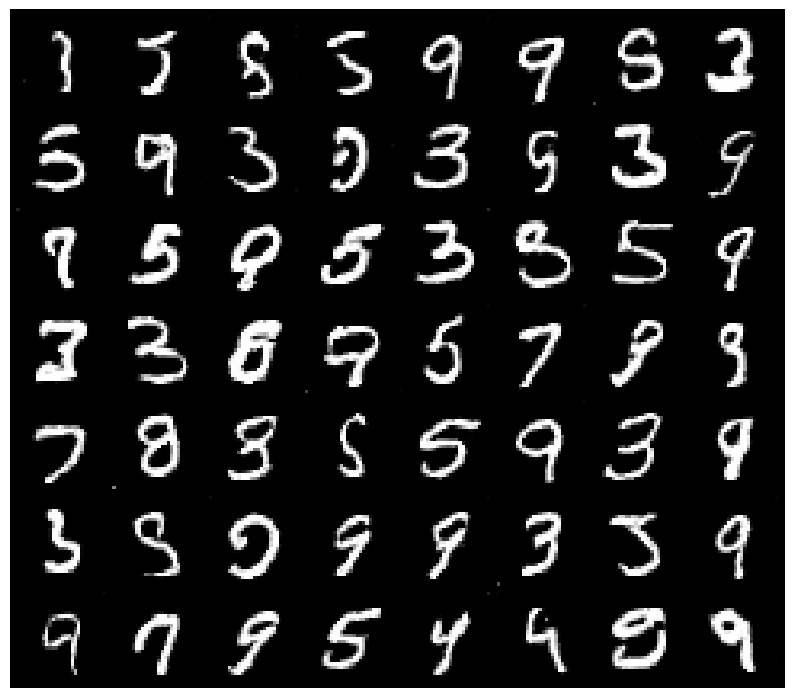

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.471, loss_G=2.66]


Epoch [35/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [35/100] - Average D loss: 0.5588, Average G loss: 2.4311


100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.27it/s, loss_D=0.429, loss_G=2.8]


Epoch [36/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [36/100] - Average D loss: 0.5562, Average G loss: 2.4193


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.643, loss_G=2.19]


Epoch [37/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [37/100] - Average D loss: 0.5602, Average G loss: 2.4087


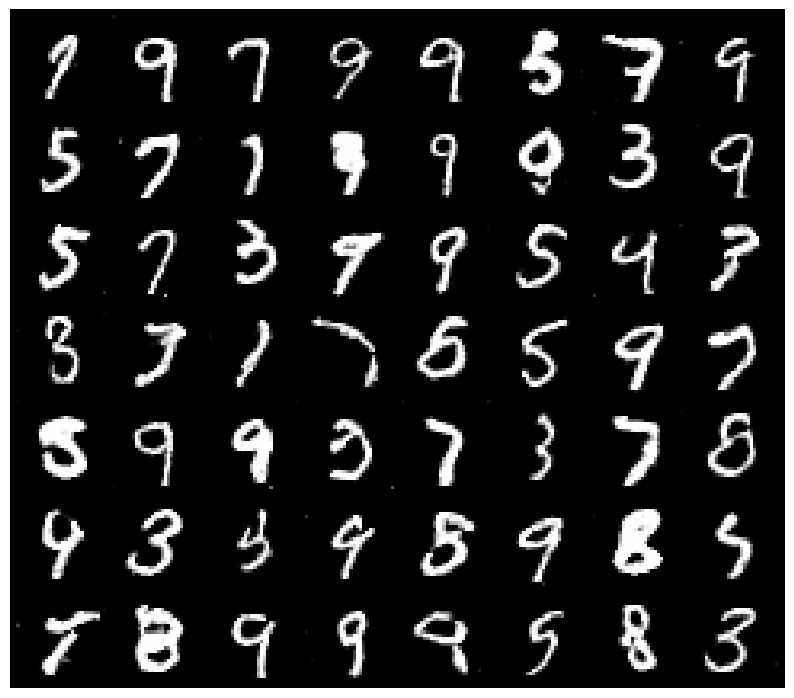

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.14it/s, loss_D=0.526, loss_G=2.56]


Epoch [38/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [38/100] - Average D loss: 0.5575, Average G loss: 2.4022


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.20it/s, loss_D=0.773, loss_G=3.29]


Epoch [39/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [39/100] - Average D loss: 0.5559, Average G loss: 2.3839


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.22it/s, loss_D=0.742, loss_G=2.34]


Epoch [40/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [40/100] - Average D loss: 0.5526, Average G loss: 2.4026


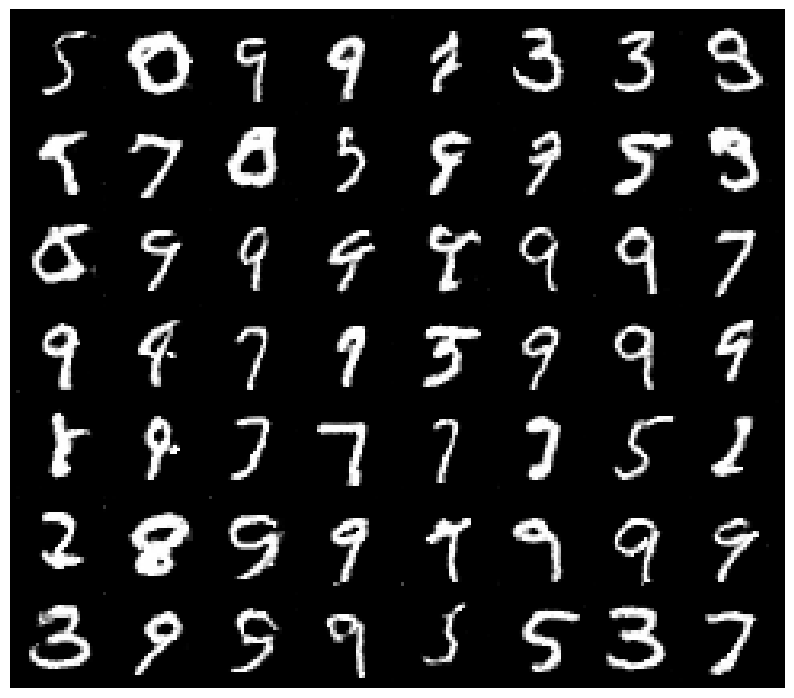

100%|████████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.512, loss_G=2]


Epoch [41/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [41/100] - Average D loss: 0.5542, Average G loss: 2.4132


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.26it/s, loss_D=0.498, loss_G=1.89]


Epoch [42/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [42/100] - Average D loss: 0.5542, Average G loss: 2.3874


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.657, loss_G=2.87]


Epoch [43/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [43/100] - Average D loss: 0.5509, Average G loss: 2.4166


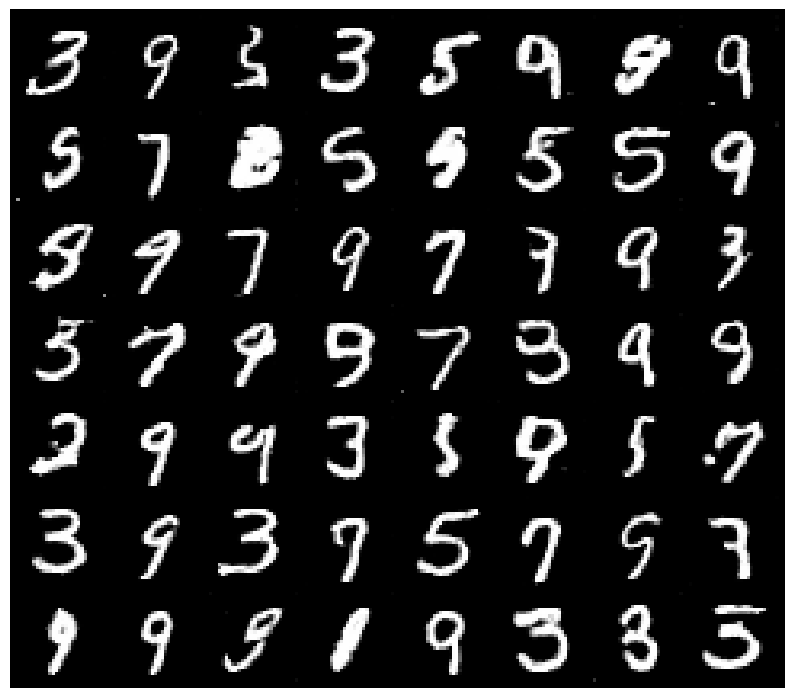

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.07it/s, loss_D=0.749, loss_G=1.95]


Epoch [44/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [44/100] - Average D loss: 0.5474, Average G loss: 2.4131


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.04it/s, loss_D=0.456, loss_G=2.12]


Epoch [45/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [45/100] - Average D loss: 0.5449, Average G loss: 2.4090


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.24it/s, loss_D=0.602, loss_G=2.38]


Epoch [46/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [46/100] - Average D loss: 0.5490, Average G loss: 2.3967


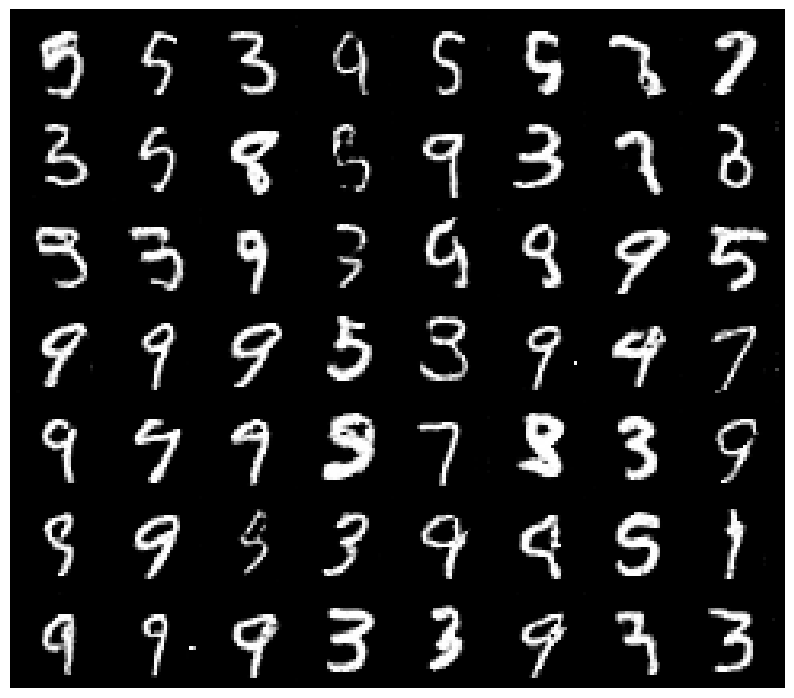

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.93it/s, loss_D=0.553, loss_G=2.51]


Epoch [47/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [47/100] - Average D loss: 0.5352, Average G loss: 2.4351


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.508, loss_G=2.41]


Epoch [48/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [48/100] - Average D loss: 0.5376, Average G loss: 2.4251


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.23it/s, loss_D=0.598, loss_G=2.15]


Epoch [49/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [49/100] - Average D loss: 0.5412, Average G loss: 2.4251


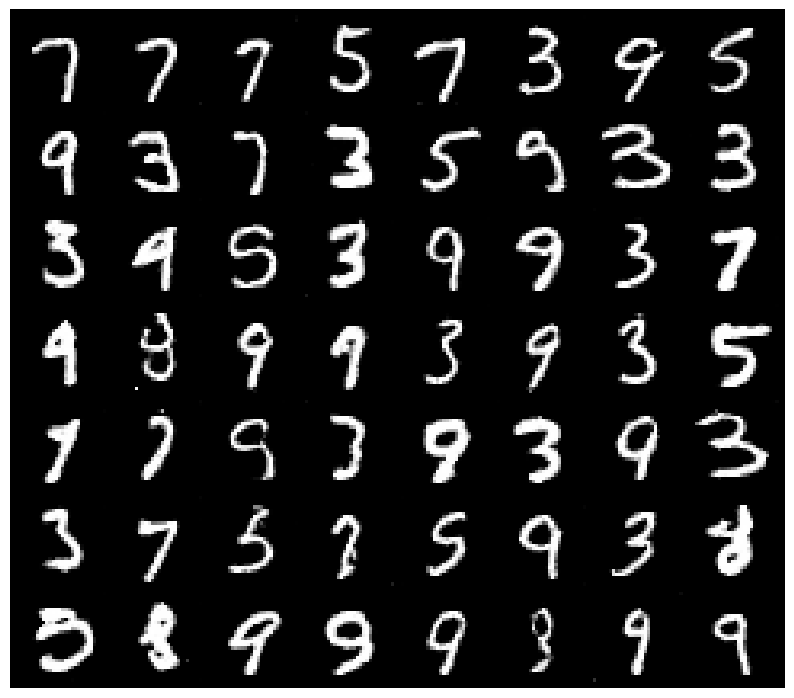

100%|████████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.01it/s, loss_D=0.543, loss_G=2]


Epoch [50/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [50/100] - Average D loss: 0.5333, Average G loss: 2.4335


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.16it/s, loss_D=0.597, loss_G=2.44]


Epoch [51/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [51/100] - Average D loss: 0.5334, Average G loss: 2.4185


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.91it/s, loss_D=0.418, loss_G=2.37]


Epoch [52/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [52/100] - Average D loss: 0.5313, Average G loss: 2.4272


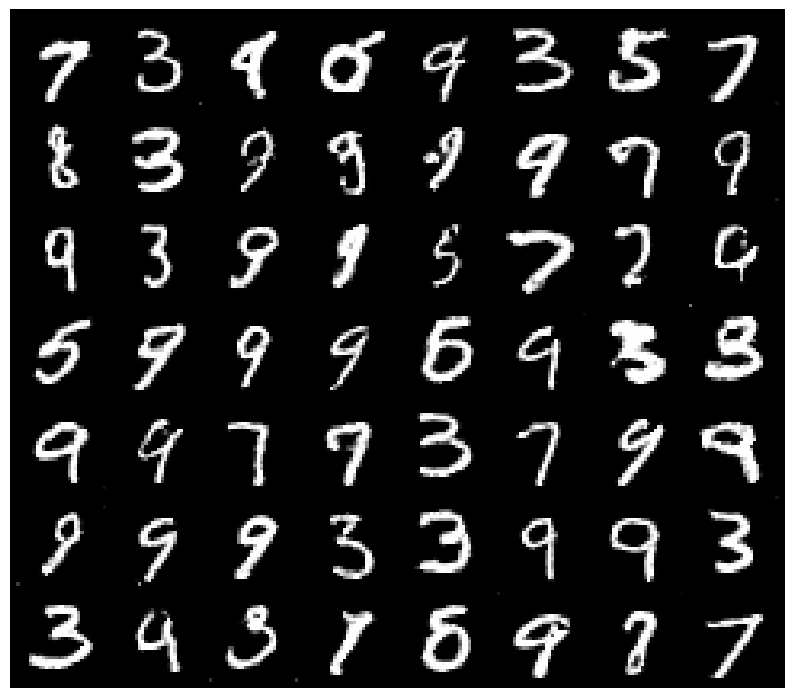

100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.17it/s, loss_D=0.47, loss_G=1.84]


Epoch [53/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [53/100] - Average D loss: 0.5266, Average G loss: 2.4347


100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.78it/s, loss_D=0.529, loss_G=2.5]


Epoch [54/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [54/100] - Average D loss: 0.5210, Average G loss: 2.4498


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.99it/s, loss_D=0.508, loss_G=2.57]


Epoch [55/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [55/100] - Average D loss: 0.5171, Average G loss: 2.4742


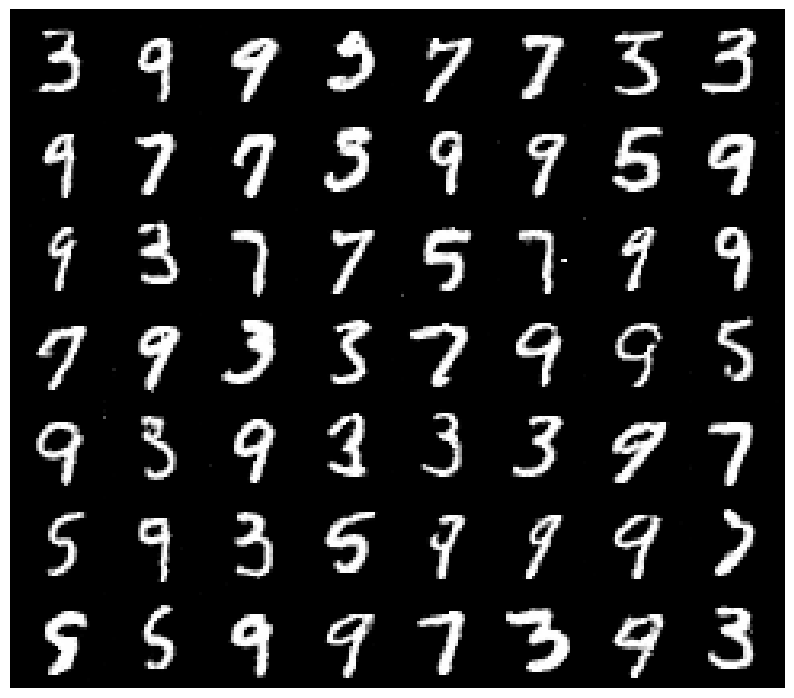

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.09it/s, loss_D=0.578, loss_G=2.08]


Epoch [56/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [56/100] - Average D loss: 0.5160, Average G loss: 2.4664


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.26it/s, loss_D=0.723, loss_G=1.87]


Epoch [57/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [57/100] - Average D loss: 0.5158, Average G loss: 2.4737


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.15it/s, loss_D=0.499, loss_G=2.88]


Epoch [58/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [58/100] - Average D loss: 0.5171, Average G loss: 2.4629


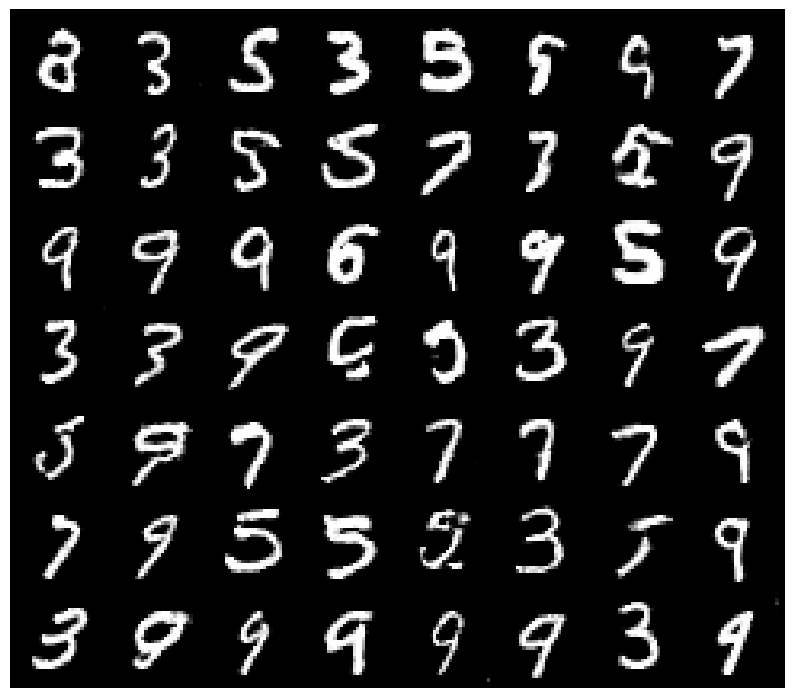

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.538, loss_G=2.15]


Epoch [59/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [59/100] - Average D loss: 0.5128, Average G loss: 2.4778


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.01it/s, loss_D=0.529, loss_G=2.5]


Epoch [60/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [60/100] - Average D loss: 0.5075, Average G loss: 2.4943


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.597, loss_G=2.54]


Epoch [61/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [61/100] - Average D loss: 0.5098, Average G loss: 2.5038


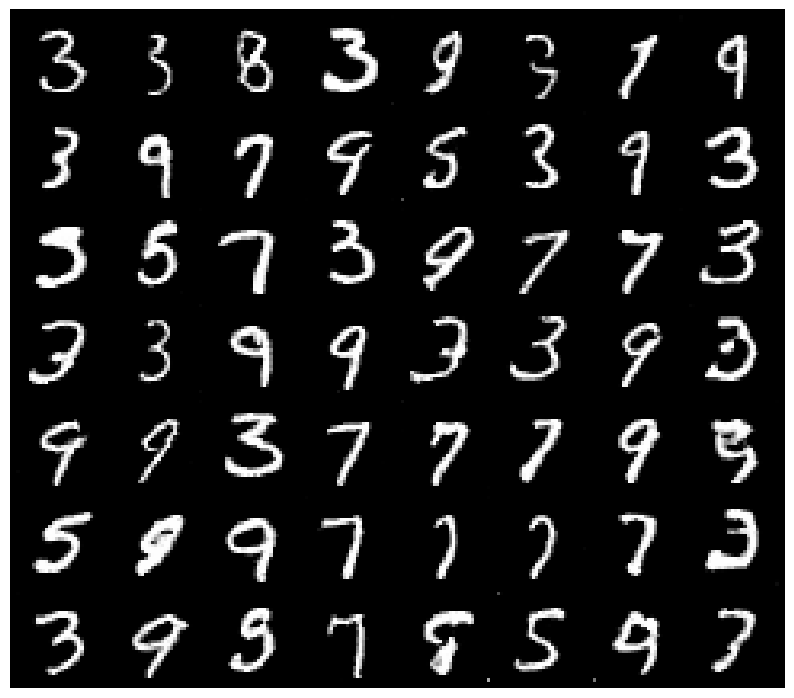

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.10it/s, loss_D=0.358, loss_G=2.52]


Epoch [62/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [62/100] - Average D loss: 0.5048, Average G loss: 2.5277


100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.14it/s, loss_D=0.339, loss_G=2.7]


Epoch [63/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [63/100] - Average D loss: 0.5041, Average G loss: 2.5137


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.86it/s, loss_D=0.405, loss_G=2.6]


Epoch [64/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [64/100] - Average D loss: 0.4957, Average G loss: 2.5542


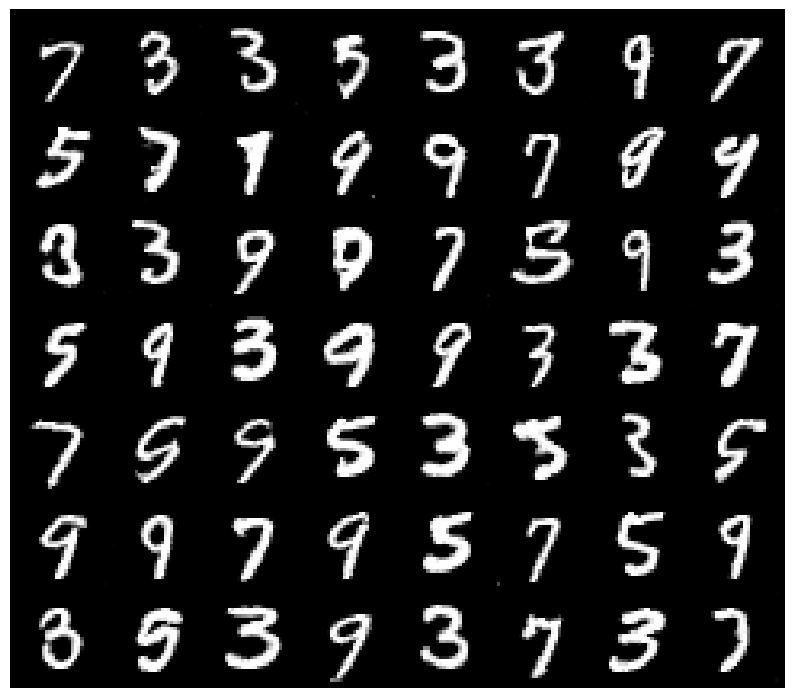

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.21it/s, loss_D=0.318, loss_G=2.74]


Epoch [65/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [65/100] - Average D loss: 0.4922, Average G loss: 2.5563


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.99it/s, loss_D=0.583, loss_G=2.52]


Epoch [66/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [66/100] - Average D loss: 0.4906, Average G loss: 2.5745


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.471, loss_G=2.55]


Epoch [67/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [67/100] - Average D loss: 0.4956, Average G loss: 2.5682


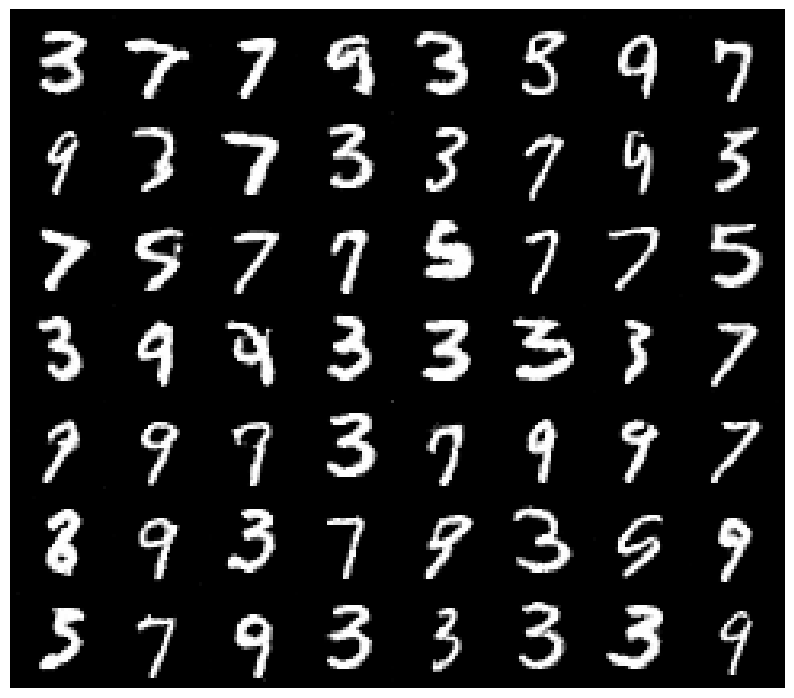

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.16it/s, loss_D=0.583, loss_G=3.12]


Epoch [68/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [68/100] - Average D loss: 0.4879, Average G loss: 2.5931


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.98it/s, loss_D=0.444, loss_G=2.61]


Epoch [69/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [69/100] - Average D loss: 0.4875, Average G loss: 2.6086


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.466, loss_G=1.97]


Epoch [70/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [70/100] - Average D loss: 0.4825, Average G loss: 2.6178


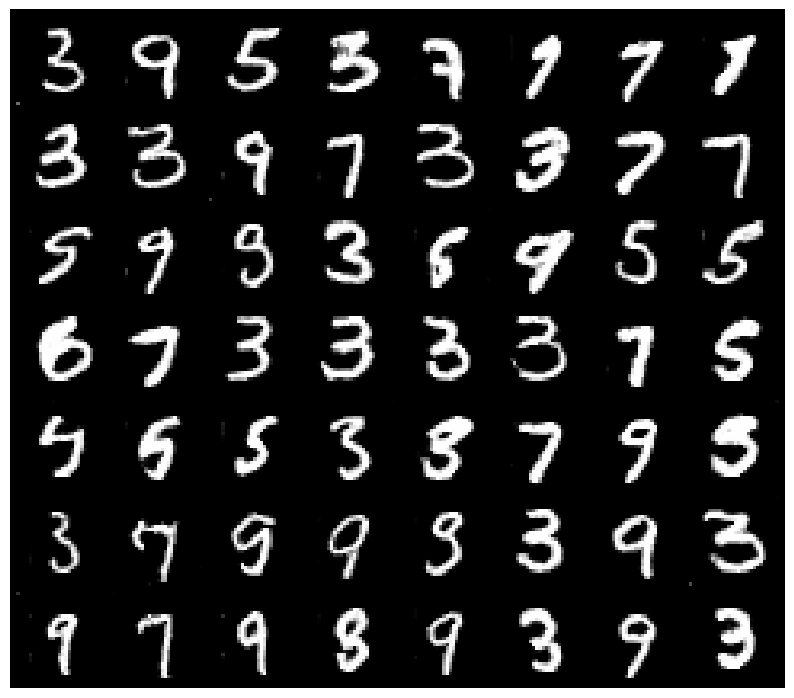

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.475, loss_G=2.69]


Epoch [71/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [71/100] - Average D loss: 0.4798, Average G loss: 2.6058


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.99it/s, loss_D=0.506, loss_G=2.3]


Epoch [72/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [72/100] - Average D loss: 0.4799, Average G loss: 2.6387


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.99it/s, loss_D=0.429, loss_G=2.44]


Epoch [73/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [73/100] - Average D loss: 0.4724, Average G loss: 2.6551


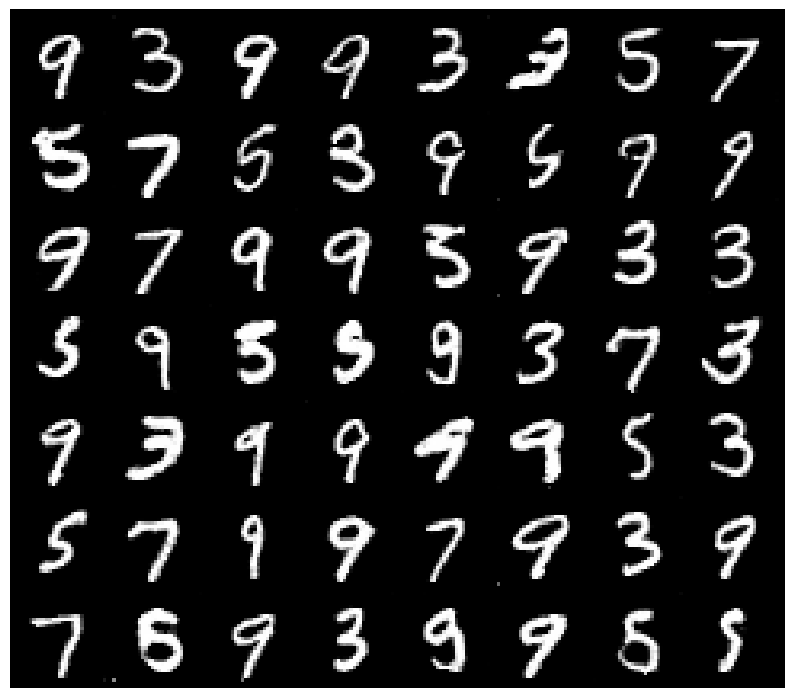

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.14it/s, loss_D=0.403, loss_G=2.45]


Epoch [74/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [74/100] - Average D loss: 0.4630, Average G loss: 2.6997


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.426, loss_G=2.33]


Epoch [75/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [75/100] - Average D loss: 0.4662, Average G loss: 2.6841


100%|███████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.44, loss_G=2.6]


Epoch [76/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [76/100] - Average D loss: 0.4627, Average G loss: 2.7066


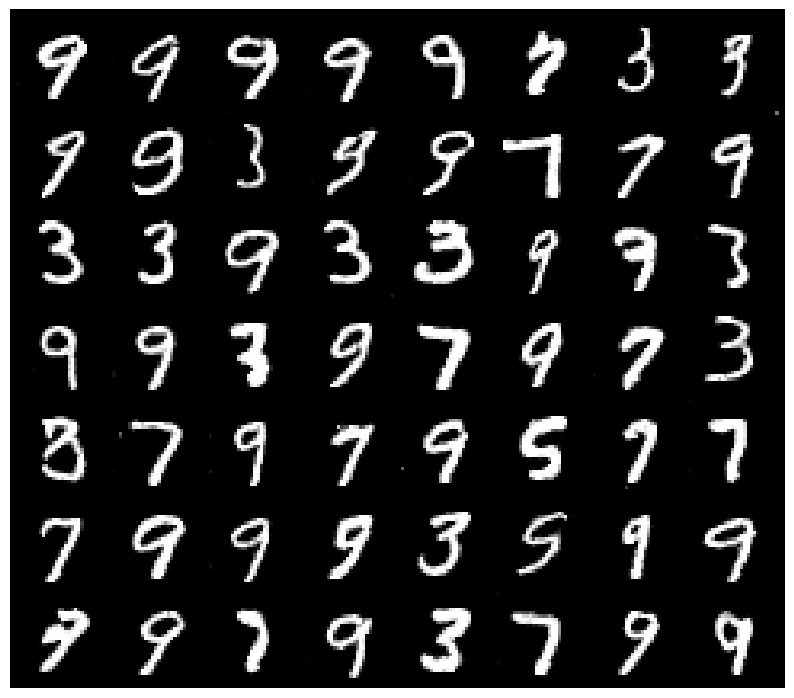

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.99it/s, loss_D=0.506, loss_G=2.49]


Epoch [77/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [77/100] - Average D loss: 0.4635, Average G loss: 2.7238


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.288, loss_G=2.67]


Epoch [78/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [78/100] - Average D loss: 0.4592, Average G loss: 2.7223


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.518, loss_G=2.42]


Epoch [79/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [79/100] - Average D loss: 0.4567, Average G loss: 2.7502


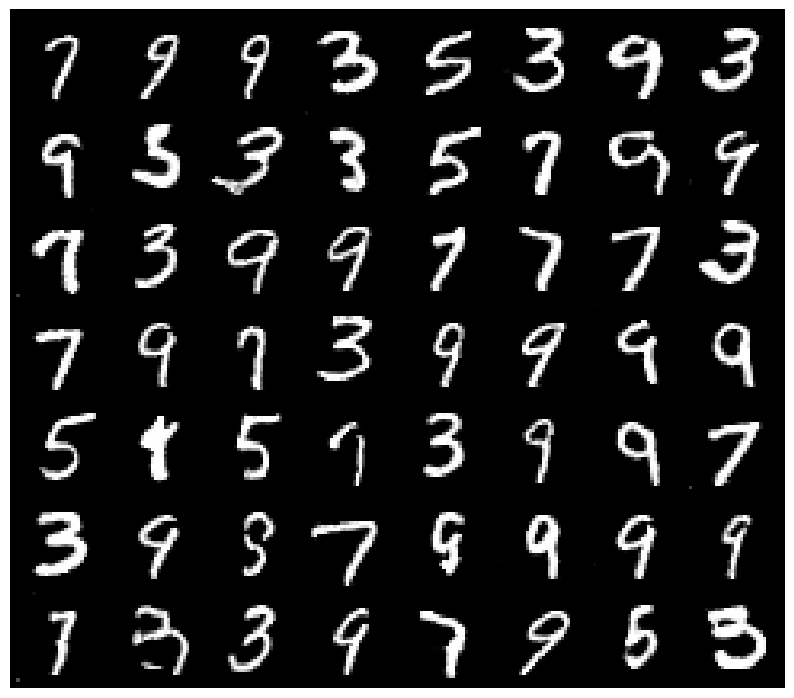

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.87it/s, loss_D=0.509, loss_G=2.37]


Epoch [80/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [80/100] - Average D loss: 0.4508, Average G loss: 2.7589


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.73it/s, loss_D=0.601, loss_G=2.65]


Epoch [81/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [81/100] - Average D loss: 0.4509, Average G loss: 2.7794


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.415, loss_G=2.65]


Epoch [82/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [82/100] - Average D loss: 0.4490, Average G loss: 2.7897


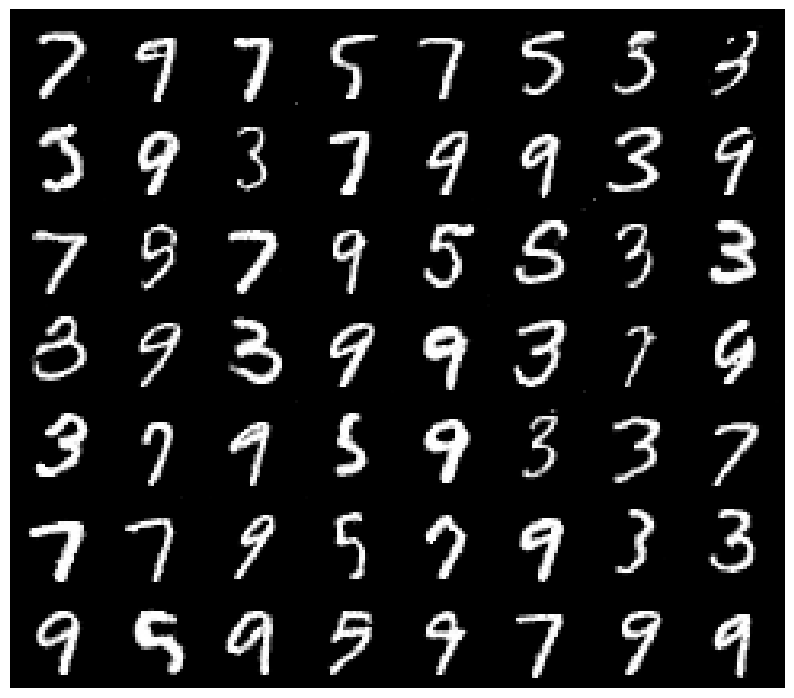

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.17it/s, loss_D=0.464, loss_G=3.13]


Epoch [83/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [83/100] - Average D loss: 0.4447, Average G loss: 2.7987


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.25it/s, loss_D=0.506, loss_G=2.83]


Epoch [84/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [84/100] - Average D loss: 0.4456, Average G loss: 2.7875


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.15it/s, loss_D=0.504, loss_G=2.94]


Epoch [85/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [85/100] - Average D loss: 0.4387, Average G loss: 2.8365


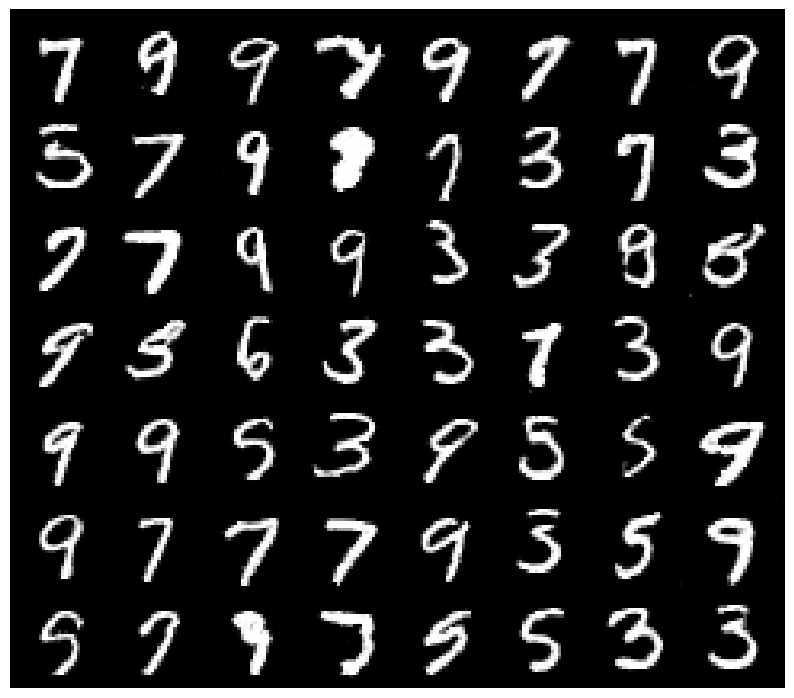

100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.16it/s, loss_D=0.54, loss_G=2.62]


Epoch [86/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [86/100] - Average D loss: 0.4371, Average G loss: 2.8488


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.422, loss_G=2.33]


Epoch [87/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [87/100] - Average D loss: 0.4381, Average G loss: 2.8637


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.00it/s, loss_D=0.372, loss_G=3.36]


Epoch [88/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [88/100] - Average D loss: 0.4324, Average G loss: 2.8601


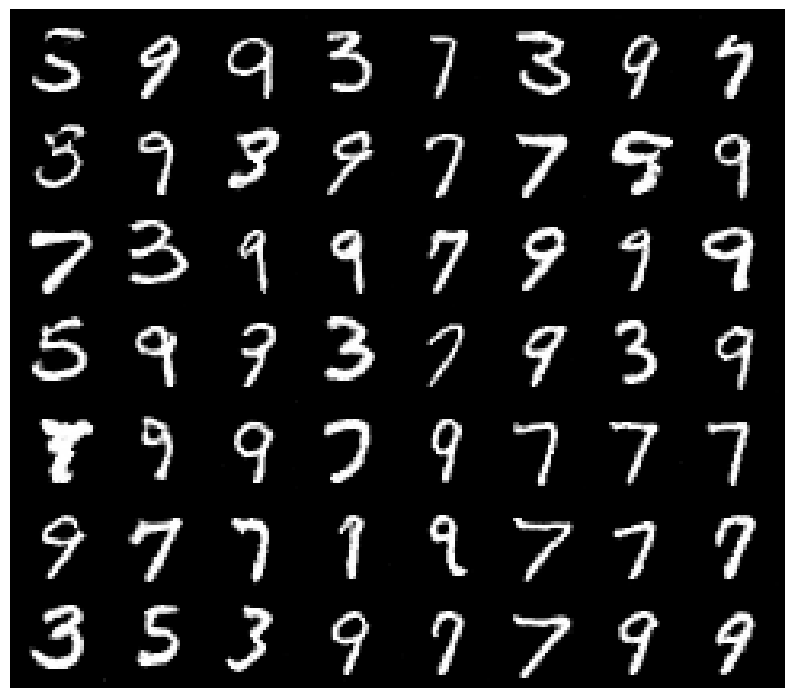

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.33it/s, loss_D=0.382, loss_G=2.44]


Epoch [89/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [89/100] - Average D loss: 0.4287, Average G loss: 2.8943


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.12it/s, loss_D=0.579, loss_G=2.57]


Epoch [90/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [90/100] - Average D loss: 0.4262, Average G loss: 2.9039


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.19it/s, loss_D=0.292, loss_G=3.38]


Epoch [91/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [91/100] - Average D loss: 0.4261, Average G loss: 2.9202


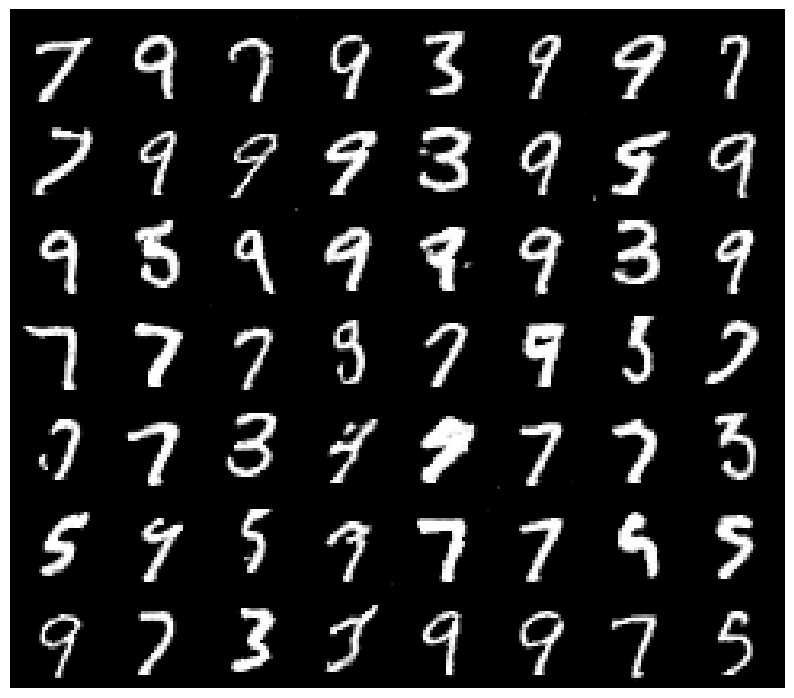

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.95it/s, loss_D=0.517, loss_G=3.31]


Epoch [92/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [92/100] - Average D loss: 0.4178, Average G loss: 2.9438


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.00it/s, loss_D=0.364, loss_G=3.42]


Epoch [93/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [93/100] - Average D loss: 0.4185, Average G loss: 2.9469


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.04it/s, loss_D=0.568, loss_G=2.14]


Epoch [94/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [94/100] - Average D loss: 0.4114, Average G loss: 2.9735


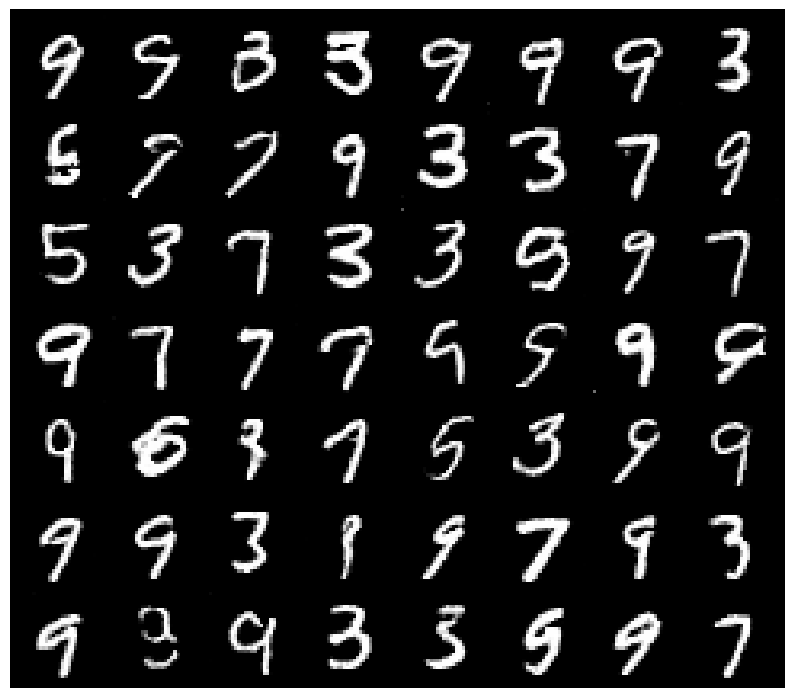

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.388, loss_G=3.31]


Epoch [95/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [95/100] - Average D loss: 0.4084, Average G loss: 2.9874


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.87it/s, loss_D=0.527, loss_G=2.42]


Epoch [96/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [96/100] - Average D loss: 0.4054, Average G loss: 2.9925


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.374, loss_G=3.66]


Epoch [97/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [97/100] - Average D loss: 0.4092, Average G loss: 2.9679


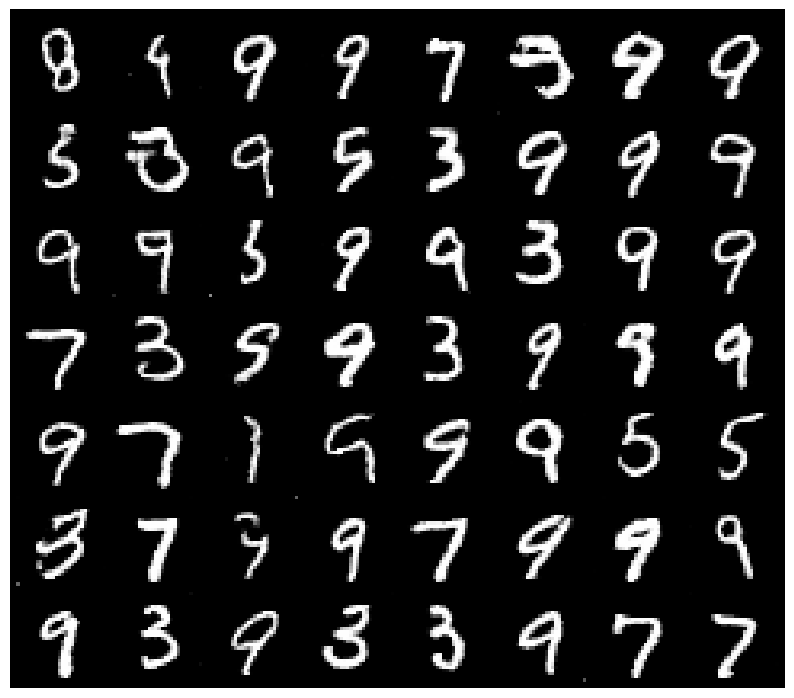

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.401, loss_G=2.61]


Epoch [98/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [98/100] - Average D loss: 0.4005, Average G loss: 3.0579


100%|█████████████████████████████████████████████████████| 732/732 [03:30<00:00,  3.48it/s, loss_D=0.288, loss_G=3.09]


Epoch [99/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [99/100] - Average D loss: 0.3953, Average G loss: 3.0768


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.411, loss_G=3.58]


Epoch [100/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [100/100] - Average D loss: 0.3909, Average G loss: 3.0921


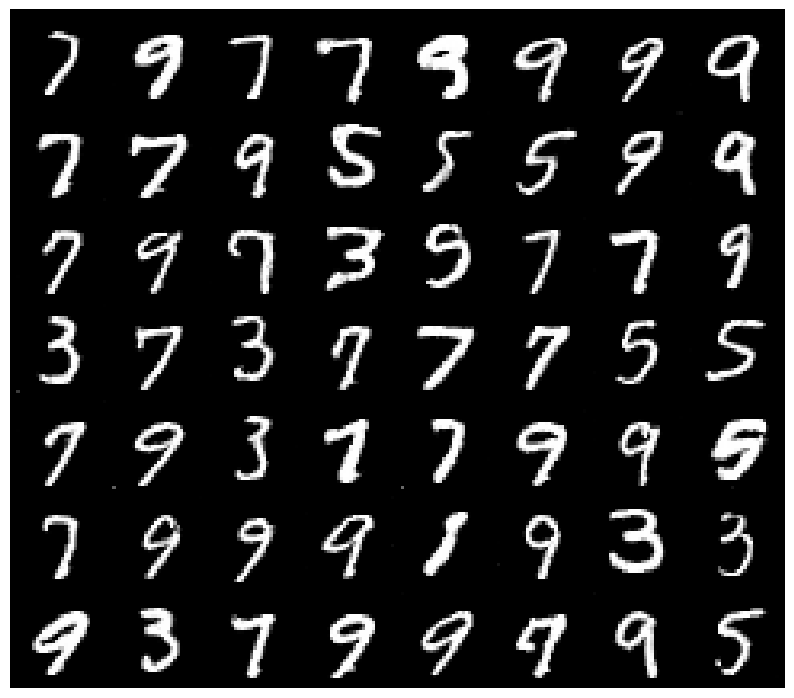

In [15]:
def preprocess_images(images):
    normalized_images = (generated_images + 1) / 2
    display_images = (normalized_images * 255).type(torch.uint8)
    return display_images

# Initialize variables
min_g_loss = float('inf')
epochs = 100
average_d_losses = []  # List to store average discriminator losses per epoch
average_g_losses = []  # List to store average generator losses per epoch

# Assume definitions of loader_discriminator, discriminator, generator, optim_D, and optim_G

for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    count_batches = 0

    loop = tqdm(loader_discriminator, leave=True, total=len(loader_discriminator))
    for real_imgs, _ in loop:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        optim_D.zero_grad()
        real_preds = discriminator(real_imgs)
        real_loss = F.binary_cross_entropy(real_preds, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = F.binary_cross_entropy(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_D.step()

        optim_G.zero_grad()
        tricked_preds = discriminator(fake_imgs)
        g_loss = F.binary_cross_entropy(tricked_preds, real_labels)
        g_loss.backward()
        optim_G.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        count_batches += 1

        loop.set_postfix(loss_D=d_loss.item(), loss_G=g_loss.item())

    avg_d_loss = total_d_loss / count_batches
    avg_g_loss = total_g_loss / count_batches

    average_d_losses.append(avg_d_loss)
    average_g_losses.append(avg_g_loss)

    # scheduler_G.step()
    # scheduler_D.step()

    lr_G = optim_G.param_groups[0]['lr']
    lr_D = optim_D.param_groups[0]['lr']

    # Print current learning rates
    print(f"Epoch [{epoch + 1}/{epochs}] - LR G: {lr_G:.7f}, LR D: {lr_D:.7f}")
    print(f"Epoch [{epoch + 1}/{epochs}] - Average D loss: {avg_d_loss:.4f}, Average G loss: {avg_g_loss:.4f}")

    if epoch % 3 == 0:
        with torch.no_grad():
            test_noise = torch.randn(batch_size, noise_dim).to(device)
            generated_images = generator(test_noise)
            generated_images = preprocess_images(generated_images)

            plt.figure(figsize=(10, 10))
            grid = make_grid(generated_images, nrow=8)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

torch.save(generator.state_dict(), 'best_generator.pth')

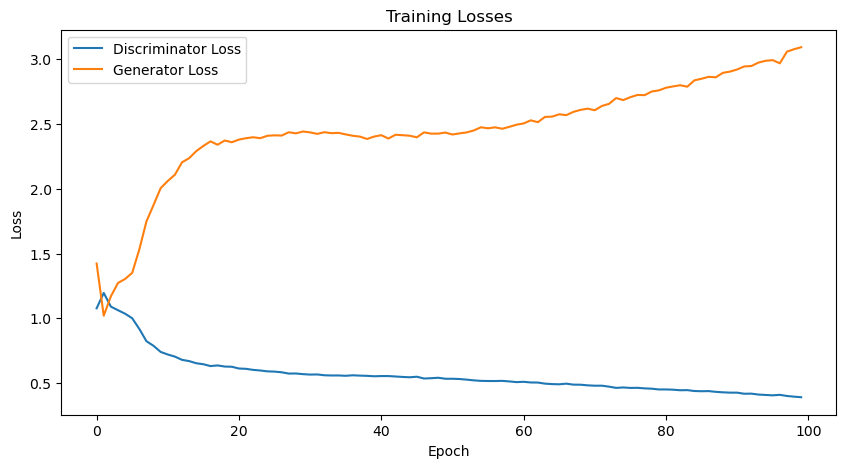

In [16]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(average_d_losses, label='Discriminator Loss')
plt.plot(average_g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
def calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O):
    """
    Calculate the output dimensions (height and width) of a transposed convolution layer.

    Parameters:
    H_in (int): Height of the input feature map.
    W_in (int): Width of the input feature map.
    K (int): Kernel size.
    S (int): Stride.
    P (int): Padding applied to the input.
    O (int): Output padding.

    Returns:
    tuple: (H_out, W_out) output height and width.
    """
    H_out = (H_in - 1) * S - 2 * P + K + O
    W_out = (W_in - 1) * S - 2 * P + K + O
    return H_out, W_out

# Example usage with specific parameters
H_in, W_in = 26, 26  # Example input dimensions
K = 3             # Kernel size
S = 1              # Stride
P = 0              # Padding
O = 0              # Output padding

# Calculate output dimensions
output_dims = calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O)
output_dims

(28, 28)

In [18]:
def calculate_conv_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output size of a convolutional layer.

    Args:
    input_size (tuple): The height and width of the input image (height, width).
    kernel_size (int): The size of the kernel/filter.
    stride (int): The stride of the convolution operation.
    padding (int): The padding added to the input image.

    Returns:
    tuple: The height and width of the output image (height, width).
    """
    input_height, input_width = input_size

    output_height = (input_height + 2 * padding - kernel_size) // stride + 1
    output_width = (input_width + 2 * padding - kernel_size) // stride + 1

    return (output_height, output_width)

# Example usage:
input_height = 28  # Example input height
input_width = 28   # Example input width
kernel_size = 3
stride = 2
padding = 2

output_size = calculate_conv_output_size((input_height, input_width), kernel_size, stride, padding)
print("Output size:", output_size)

Output size: (15, 15)


In [19]:
# Load the trained generator weights
generator.load_state_dict(torch.load('best_generator.pth'))
generator.eval()  # Set to evaluation mode

Generator(
  (fc): Linear(in_features=49, out_features=49, bias=True)
  (convT1): ConvTranspose2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (convT5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)

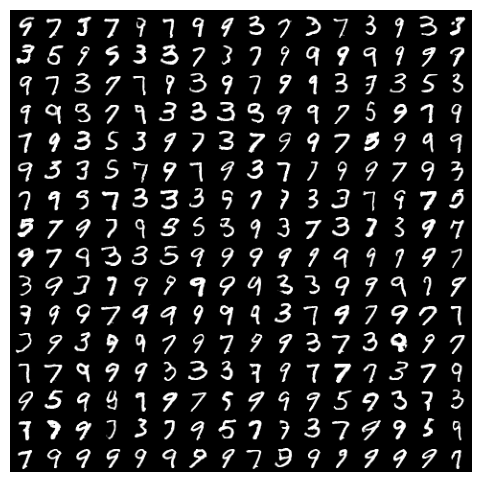

In [20]:
# Generate noise vectors
batch_size = 256  # Number of images to generate
noise = torch.randn(batch_size, noise_dim).to(device)

# Generate images from noise vectors
with torch.no_grad():
    fake_images = generator(noise)

# Assuming images are 28x28 and need to be reshaped
fake_images = fake_images.view(batch_size, 1, 28, 28)  # Reshape images to BxCxHxW format if needed
grid = make_grid(fake_images, nrow=16, normalize=True)  # Create a grid of images

# Visualize images
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Adjust the channel ordering
plt.axis('off')
plt.show()
